In [24]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours

In [25]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip
!unzip -qo data.zip

--2021-11-26 10:34:01--  https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.158.27
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.158.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28437489 (27M) [application/x-zip-compressed]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]  27.12M  14.0MB/s    in 1.9s    

2021-11-26 10:34:04 (14.0 MB/s) - ‘data.zip.1’ saved [28437489/28437489]



In [26]:
x = []
y = []
datadir = 'data/dataset'
for folder in os.listdir(datadir):
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)
        
print(len(x))
print(len(y))
print(f'labels : {list(set(y))}')

7600
7600
labels : ['9', 'add', '1', '0', 'div', '3', '5', 'mul', '6', '2', '8', '4', 'sub', '7']


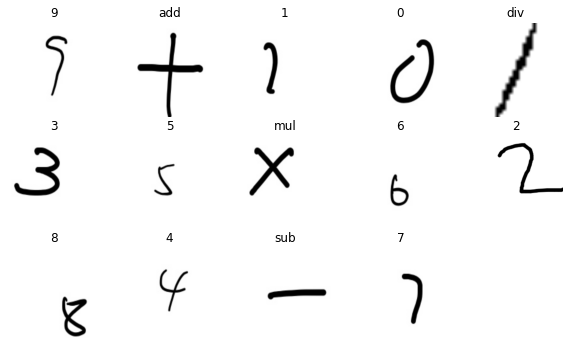

In [27]:
figure = plt.figure(figsize=(10, 10))
j = 0
for i in list(set(y)):
    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


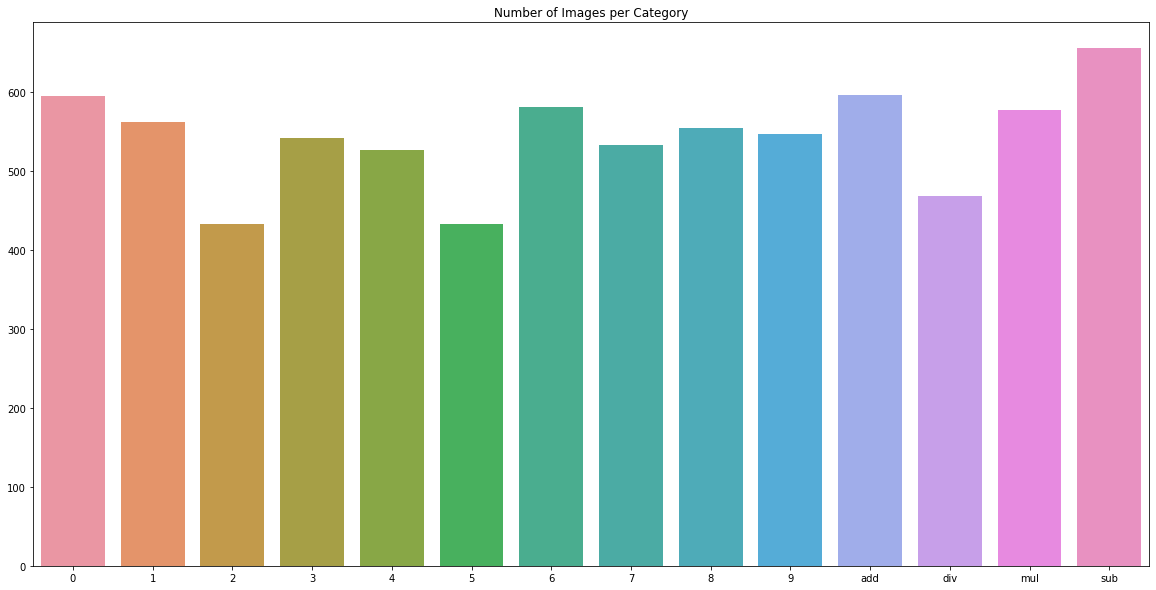

In [28]:
unique, count = np.unique(y, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(unique, count).set_title('Number of Images per Category')
plt.show()

In [29]:
X = []
for i in range(len(x)):
#     print(i)
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)
print(len(X))

7600


In [30]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(len(y))

7600


In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


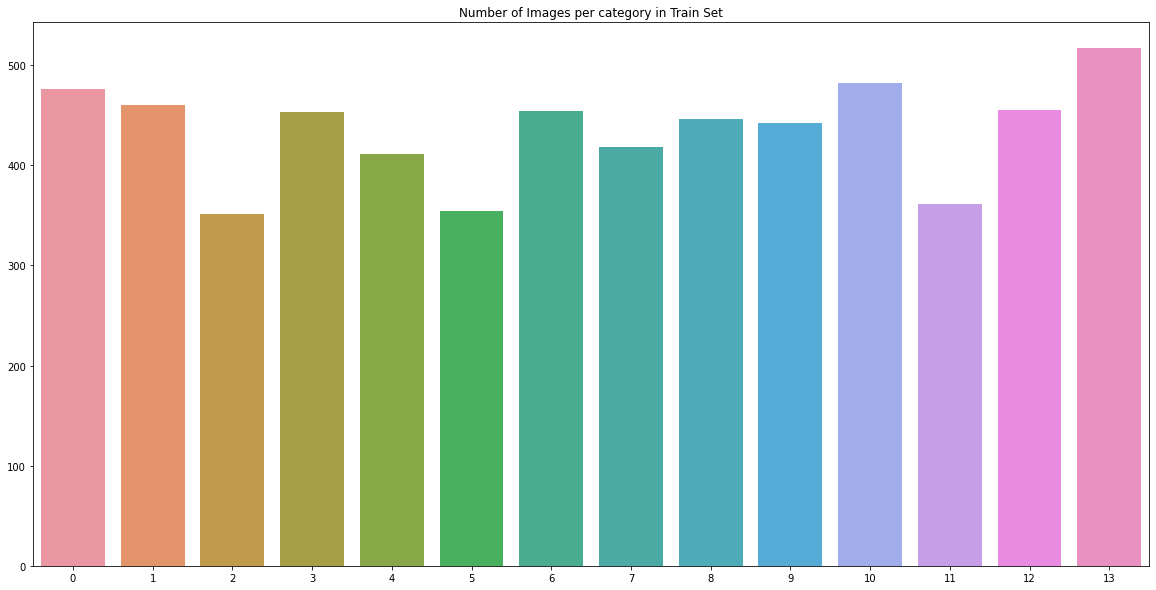

In [32]:
unique_train, count_train = np.unique(Y_train, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(unique_train, count_train).set_title('Number of Images per category in Train Set')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


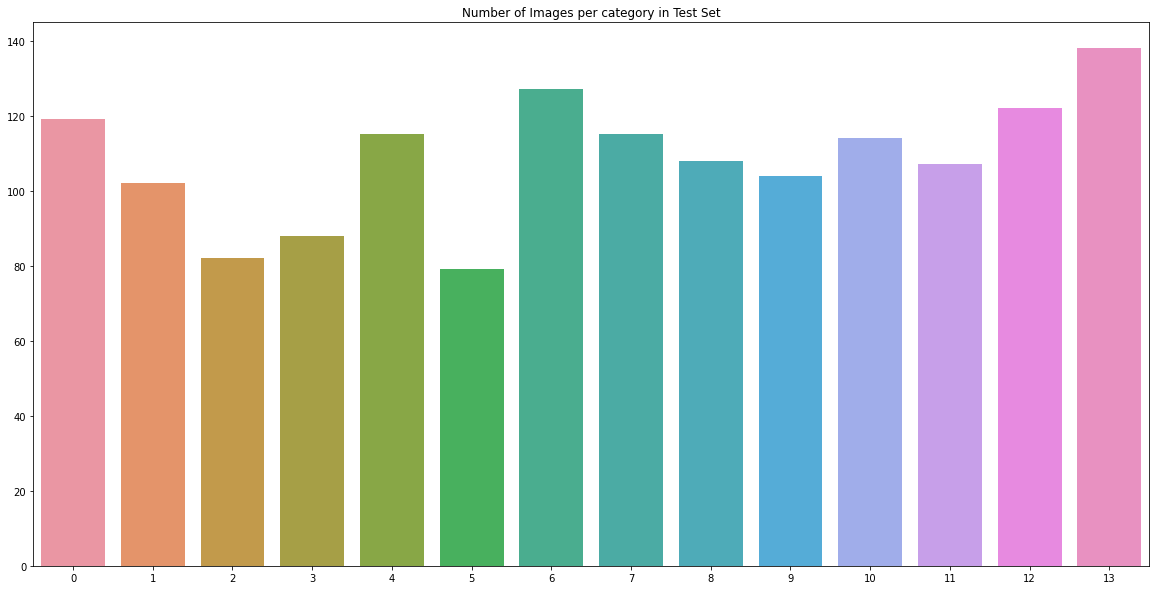

In [33]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(unique_test, count_test).set_title('Number of Images per category in Test Set')
plt.show()

In [34]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6080, 32, 32, 1)
(1520, 32, 32, 1)
(6080, 14)
(1520, 14)


In [35]:
def math_symbol_and_digits_recognition(input_shape=(32, 32, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(14, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [36]:
model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        320       
                                                                 
 act1 (Activation)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 act2 (Activation)           (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                  

In [37]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('maths_symbol_and_digits_recognition.h5', 
                             monitor='val_loss', save_best_only=True, 
                             verbose=1, mode='min')

callbacks = [checkpoint, LearningRateScheduler(step_decay)]

In [15]:
aug = ImageDataGenerator(zoom_range=0.1,
#                          rotation_range=5,
                         width_shift_range=0.05,
                         height_shift_range=0.05)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=50, validation_data=(X_test, Y_test))
# hist2 = model2.fit(X_train, Y_train, batch_size=128, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

Epoch 1/50
48/48 [==============================] - 16s 63ms/step - loss: 2.9161 - accuracy: 0.1984 - val_loss: 2.3358 - val_accuracy: 0.4474
Epoch 2/50
48/48 [==============================] - 3s 54ms/step - loss: 1.7399 - accuracy: 0.5663 - val_loss: 1.4462 - val_accuracy: 0.6882
Epoch 3/50
48/48 [==============================] - 3s 55ms/step - loss: 1.1662 - accuracy: 0.7209 - val_loss: 1.1291 - val_accuracy: 0.7763
Epoch 4/50
48/48 [==============================] - 3s 54ms/step - loss: 0.9327 - accuracy: 0.7817 - val_loss: 1.0273 - val_accuracy: 0.7645
Epoch 5/50
48/48 [==============================] - 3s 55ms/step - loss: 0.8112 - accuracy: 0.8117 - val_loss: 1.0617 - val_accuracy: 0.7362
Epoch 6/50
48/48 [==============================] - 3s 54ms/step - loss: 0.6989 - accuracy: 0.8467 - val_loss: 1.0383 - val_accuracy: 0.7487
Epoch 7/50
48/48 [==============================] - 3s 54ms/step - loss: 0.6692 - accuracy: 0.8457 - val_loss: 0.8670 - val_accuracy: 0.7974
Epoch 8/50
4

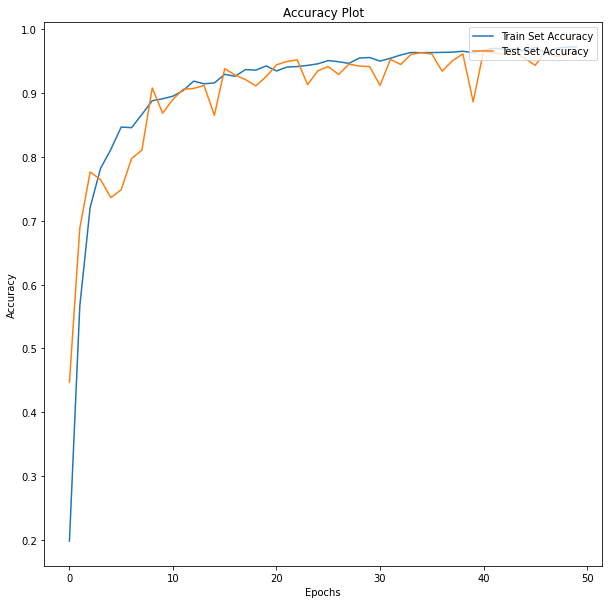

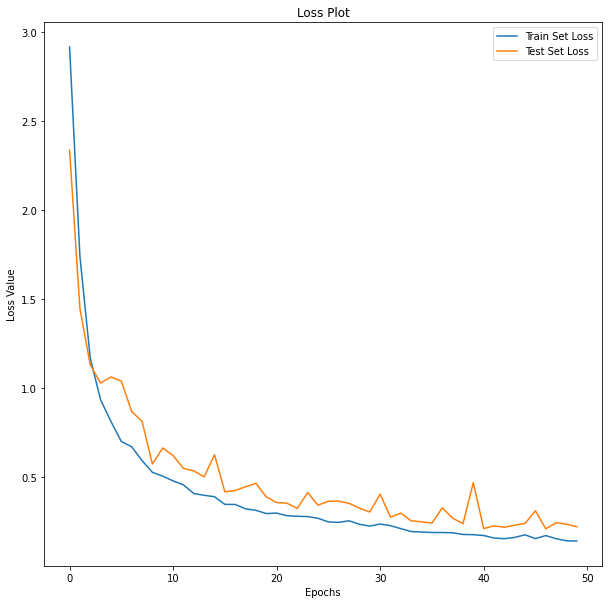

In [16]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

In [17]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_hat, ypred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       126
           1       1.00      0.90      0.95       103
           2       0.98      0.98      0.98        92
           3       0.97      0.94      0.96       123
           4       0.92      0.93      0.93        92
           5       0.99      0.95      0.97        86
           6       0.97      0.94      0.95       118
           7       0.95      0.94      0.94        98
           8       0.87      0.98      0.92       103
           9       0.94      0.96      0.95       108
          10       0.98      0.97      0.98       103
          11       1.00      1.00      1.00        94
          12       0.99      0.99      0.99       137
          13       1.00      1.00      1.00       137

    accuracy                           0.96      1520
   macro avg       0.96      0.96      0.96      1520
weighted avg       0.96      0.96      0.96      1520



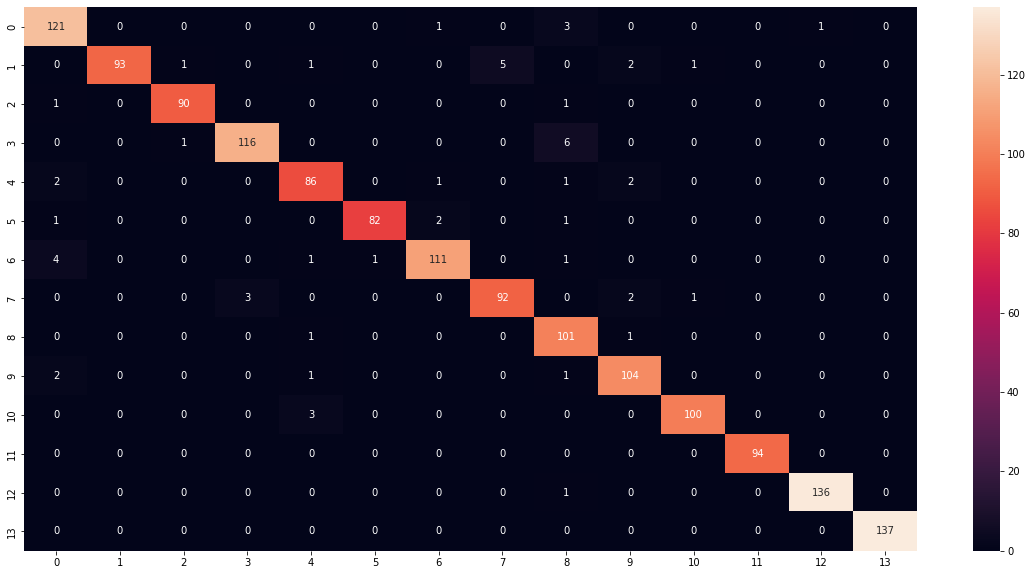

In [18]:
matrix = confusion_matrix(Y_test_hat, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 
                     columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
figure = plt.figure(figsize=(20, 10))
sn.heatmap(df_cm, annot=True, fmt='d')

In [19]:
model.save('maths_symbol_and_digit_recognition.h5')

In [20]:
def test_pipeline(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # blurred = cv2.GaussianBlur(img_gray, (3, 3), 0)
    edged = cv2.Canny(img_gray, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sort_contours(contours, method="left-to-right")[0]
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if 20<=w and 30<=h:
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw)/2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            padded = np.array(padded)
            padded = padded/255.
            padded = np.expand_dims(padded, axis=0)
            padded = np.expand_dims(padded, axis=-1)
            pred = model.predict(padded)
            pred = np.argmax(pred, axis=1)
            label = labels[pred[0]]
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

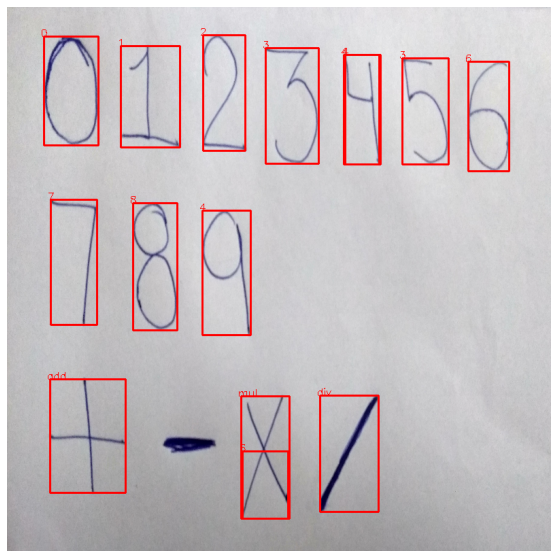

In [21]:
test_pipeline('data/test.jpg') #add your image here

In [22]:
def test_pipeline_equation(image_path):
    chars = []
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # blurred = cv2.GaussianBlur(img_gray, (3, 3), 0)
    edged = cv2.Canny(img_gray, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sort_contours(contours, method="left-to-right")[0]
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if 20<=w and 30<=h:
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw)/2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            padded = np.array(padded)
            padded = padded/255.
            padded = np.expand_dims(padded, axis=0)
            padded = np.expand_dims(padded, axis=-1)
            pred = model.predict(padded)
            pred = np.argmax(pred, axis=1)
    #         print(pred)
            label = labels[pred[0]]
            chars.append(label)
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    e = ''
    for i in chars:
        if i=='add':
            e += '+'
        elif i=='sub':
            e += '-'
        elif i=='mul':
            e += '*'
        elif i=='div':
            e += '/'
        else:
            e += i
    v = eval(e)
    print('Value of the expression {} : {}'.format(e, v)) 

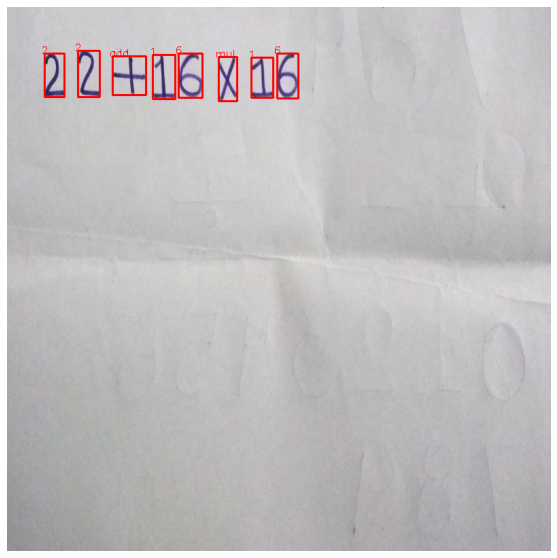

Value of the expression 22+16*16 : 278


In [23]:
test_pipeline_equation('data/test_equation4.jpg')